# Task 4- Lunar Lander With Proximal Policy Optimization(PPO)

Our enivronemnt is based on OpenAi Gym Lunar Lander environment. See
https://gym.openai.com/envs/LunarLander-v2/

Our aim is to land the a spaseship on the landing spot between the two flags without crashing .

In [3]:
import gym
from luna_lander import PPO_Agent
from luna_lander import experiment_luna_lander, run_episodes,plot_all_experiments,plot_episodes,save_to_pickle, load_from_pickle
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import os
import torch
import datetime
import luna_lander
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')


In [4]:
#Please make sure these folder exists
SAVED_DIR='./luna_lander/saved'
RUNS_DIR='./luna_lander/experiments'


SAVED_BEST='./luna_lander/saved/best'

PICKLE_PPO_RESULTS='./luna_lander/saved/best/ppo_results_dict.pkl'

### In this task I will use the Lunar lander discrete environemnt

https://gym.openai.com/envs/LunarLander-v2/

**From Gym environemnt descripition**:

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

Demonstration of the environment

In [3]:
#This is borrowed from gym environemnt example. See: https://gym.openai.com/docs/
import gym
env = gym.make('LunarLanderContinuous-v2')#)
env.reset()
for _ in range(1000):
    #env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

### PPO Agent

from https://spinningup.openai.com/en/latest/algorithms/ppo.html

![title](images/ppo.png)  

#### Device and seed selection

In [5]:
#Device selection
device = torch.device('cpu')
if (torch.cuda.is_available()):
    device = torch.device('cuda:1')

print(device)



cuda:1


In [6]:
#Repsroducible results
SEED=42

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## Running PPO model

I will run 5 experiments of PPO .Each will run for 200 episodes and will avarage the results. 

In [14]:

#Running avarages of 20 
NUM_EPISODES_AVG=20


#We will run for 200 episodes
NUM_EPISODES = 200


#Configuration fro PPO
CONFIGS_PPO_LUNA_LANDER = [
        {'run_name': "PPO_critic:400-300actor:400-300lr_actor_3e-5", 'batch_size': 64,
         "critic_linear_sizes": [400, 300], "actor_linear_sizes": [400, 300], "config_optim": {'lr': 0.00003}
         , "capacity": 1024, "lambda_smoothing": 0.95, "num_epochs": 5,
         "gamma": 0.99, "checkpoint": None}]

NUM_EXPERIMENTS = 5
BATCH_SIZE = 64



*********Start Running config: PPO_critic:400-300actor:400-300lr_actor_3e-5*************
Episode 0/200 Total Reward: -5.09 Num Timesteps: 97.00 Avg Reward: -5.09 Avg Timesteps: 97.00
Episode 1/200 Total Reward: -108.92 Num Timesteps: 69.00 Avg Reward: -57.01 Avg Timesteps: 83.00
Episode 2/200 Total Reward: -135.71 Num Timesteps: 73.00 Avg Reward: -83.24 Avg Timesteps: 79.67
Episode 3/200 Total Reward: -122.69 Num Timesteps: 67.00 Avg Reward: -93.10 Avg Timesteps: 76.50
Episode 4/200 Total Reward: -183.81 Num Timesteps: 59.00 Avg Reward: -111.25 Avg Timesteps: 73.00
Episode 5/200 Total Reward: -325.16 Num Timesteps: 68.00 Avg Reward: -146.90 Avg Timesteps: 72.17
Episode 6/200 Total Reward: -145.42 Num Timesteps: 88.00 Avg Reward: -146.69 Avg Timesteps: 74.43
Episode 7/200 Total Reward: -157.59 Num Timesteps: 81.00 Avg Reward: -148.05 Avg Timesteps: 75.25
Episode 8/200 Total Reward: -370.29 Num Timesteps: 112.00 Avg Reward: -172.74 Avg Timesteps: 79.33
Episode 9/200 Total Reward: -376.35

Episode 82/200 Total Reward: -47.44 Num Timesteps: 207.00 Avg Reward: -83.88 Avg Timesteps: 172.00
Episode 83/200 Total Reward: 111.90 Num Timesteps: 1000.00 Avg Reward: -65.38 Avg Timesteps: 212.65
Episode 84/200 Total Reward: 106.74 Num Timesteps: 1000.00 Avg Reward: -54.85 Avg Timesteps: 255.65
Episode 85/200 Total Reward: -249.92 Num Timesteps: 856.00 Avg Reward: -65.93 Avg Timesteps: 288.55
Episode 86/200 Total Reward: -123.80 Num Timesteps: 672.00 Avg Reward: -69.63 Avg Timesteps: 315.55
Episode 87/200 Total Reward: -125.83 Num Timesteps: 1000.00 Avg Reward: -72.19 Avg Timesteps: 359.00
Episode 88/200 Total Reward: -69.08 Num Timesteps: 1000.00 Avg Reward: -74.37 Avg Timesteps: 403.95
Episode 89/200 Total Reward: -57.72 Num Timesteps: 1000.00 Avg Reward: -72.19 Avg Timesteps: 449.20
Episode 90/200 Total Reward: -61.73 Num Timesteps: 1000.00 Avg Reward: -71.24 Avg Timesteps: 491.30
Episode 91/200 Total Reward: -80.08 Num Timesteps: 1000.00 Avg Reward: -62.60 Avg Timesteps: 537.20


Episode 164/200 Total Reward: 210.18 Num Timesteps: 831.00 Avg Reward: -95.00 Avg Timesteps: 723.35
Episode 165/200 Total Reward: 190.58 Num Timesteps: 326.00 Avg Reward: -92.31 Avg Timesteps: 701.55
Episode 166/200 Total Reward: 229.02 Num Timesteps: 524.00 Avg Reward: -77.04 Avg Timesteps: 677.75
Episode 167/200 Total Reward: 243.13 Num Timesteps: 410.00 Avg Reward: -53.14 Avg Timesteps: 655.55
Episode 168/200 Total Reward: 227.54 Num Timesteps: 982.00 Avg Reward: -41.69 Avg Timesteps: 654.65
Episode 169/200 Total Reward: 111.58 Num Timesteps: 1000.00 Avg Reward: -32.27 Avg Timesteps: 667.80
Episode 170/200 Total Reward: 231.95 Num Timesteps: 401.00 Avg Reward: -11.44 Avg Timesteps: 640.80
Episode 171/200 Total Reward: 119.48 Num Timesteps: 1000.00 Avg Reward: 5.02 Avg Timesteps: 649.05
Episode 172/200 Total Reward: 224.29 Num Timesteps: 310.00 Avg Reward: 13.89 Avg Timesteps: 614.55
Episode 173/200 Total Reward: 262.96 Num Timesteps: 331.00 Avg Reward: 44.53 Avg Timesteps: 591.10
Ep

Episode 47/200 Total Reward: -74.01 Num Timesteps: 107.00 Avg Reward: -118.95 Avg Timesteps: 104.10
Episode 48/200 Total Reward: -40.76 Num Timesteps: 62.00 Avg Reward: -103.67 Avg Timesteps: 102.65
Episode 49/200 Total Reward: -112.55 Num Timesteps: 65.00 Avg Reward: -93.22 Avg Timesteps: 101.50
Episode 50/200 Total Reward: -126.86 Num Timesteps: 145.00 Avg Reward: -82.62 Avg Timesteps: 100.45
Episode 51/200 Total Reward: -34.09 Num Timesteps: 104.00 Avg Reward: -73.02 Avg Timesteps: 101.80
Episode 52/200 Total Reward: -83.37 Num Timesteps: 95.00 Avg Reward: -71.20 Avg Timesteps: 102.60
Episode 53/200 Total Reward: -9.61 Num Timesteps: 127.00 Avg Reward: -66.92 Avg Timesteps: 103.85
Episode 54/200 Total Reward: 10.23 Num Timesteps: 119.00 Avg Reward: -63.51 Avg Timesteps: 104.10
Episode 55/200 Total Reward: -26.68 Num Timesteps: 94.00 Avg Reward: -64.38 Avg Timesteps: 100.35
Episode 56/200 Total Reward: -83.02 Num Timesteps: 201.00 Avg Reward: -63.26 Avg Timesteps: 104.80
Episode 57/2

Episode 130/200 Total Reward: 172.21 Num Timesteps: 726.00 Avg Reward: 111.54 Avg Timesteps: 543.50
Episode 131/200 Total Reward: 109.41 Num Timesteps: 610.00 Avg Reward: 120.70 Avg Timesteps: 557.40
Episode 132/200 Total Reward: 126.58 Num Timesteps: 873.00 Avg Reward: 115.50 Avg Timesteps: 574.95
Episode 133/200 Total Reward: 120.31 Num Timesteps: 954.00 Avg Reward: 112.67 Avg Timesteps: 589.80
Episode 134/200 Total Reward: -45.08 Num Timesteps: 622.00 Avg Reward: 111.88 Avg Timesteps: 600.85
Episode 135/200 Total Reward: 158.65 Num Timesteps: 793.00 Avg Reward: 107.35 Avg Timesteps: 606.80
Episode 136/200 Total Reward: -114.33 Num Timesteps: 389.00 Avg Reward: 103.21 Avg Timesteps: 612.80
Episode 137/200 Total Reward: 81.49 Num Timesteps: 1000.00 Avg Reward: 109.43 Avg Timesteps: 646.35
Episode 138/200 Total Reward: -38.09 Num Timesteps: 382.00 Avg Reward: 95.75 Avg Timesteps: 639.30
Episode 139/200 Total Reward: -77.74 Num Timesteps: 288.00 Avg Reward: 81.39 Avg Timesteps: 636.75
E

Episode 14/200 Total Reward: -106.54 Num Timesteps: 95.00 Avg Reward: -279.89 Avg Timesteps: 99.93
Episode 15/200 Total Reward: -119.06 Num Timesteps: 64.00 Avg Reward: -269.84 Avg Timesteps: 97.69
Episode 16/200 Total Reward: -230.90 Num Timesteps: 97.00 Avg Reward: -267.55 Avg Timesteps: 97.65
Episode 17/200 Total Reward: -116.34 Num Timesteps: 125.00 Avg Reward: -259.15 Avg Timesteps: 99.17
Episode 18/200 Total Reward: -118.56 Num Timesteps: 79.00 Avg Reward: -251.75 Avg Timesteps: 98.11
Episode 19/200 Total Reward: -182.24 Num Timesteps: 92.00 Avg Reward: -248.27 Avg Timesteps: 97.80
Episode 20/200 Total Reward: -32.02 Num Timesteps: 91.00 Avg Reward: -242.43 Avg Timesteps: 97.95
Episode 21/200 Total Reward: -301.87 Num Timesteps: 94.00 Avg Reward: -233.37 Avg Timesteps: 97.70
Episode 22/200 Total Reward: -105.59 Num Timesteps: 83.00 Avg Reward: -233.34 Avg Timesteps: 97.75
Episode 23/200 Total Reward: -217.26 Num Timesteps: 112.00 Avg Reward: -221.20 Avg Timesteps: 98.85
Episode 2

Episode 97/200 Total Reward: -52.66 Num Timesteps: 1000.00 Avg Reward: -42.26 Avg Timesteps: 389.85
Episode 98/200 Total Reward: 106.44 Num Timesteps: 945.00 Avg Reward: -34.15 Avg Timesteps: 432.10
Episode 99/200 Total Reward: -69.69 Num Timesteps: 1000.00 Avg Reward: -35.96 Avg Timesteps: 472.90
Episode 100/200 Total Reward: 135.11 Num Timesteps: 839.00 Avg Reward: -24.17 Avg Timesteps: 504.15
Episode 101/200 Total Reward: -137.61 Num Timesteps: 1000.00 Avg Reward: -30.16 Avg Timesteps: 545.40
Episode 102/200 Total Reward: -262.41 Num Timesteps: 978.00 Avg Reward: -42.12 Avg Timesteps: 581.80
Episode 103/200 Total Reward: -35.12 Num Timesteps: 1000.00 Avg Reward: -35.09 Avg Timesteps: 621.90
Episode 104/200 Total Reward: -95.10 Num Timesteps: 1000.00 Avg Reward: -48.13 Avg Timesteps: 621.90
Episode 105/200 Total Reward: -53.58 Num Timesteps: 1000.00 Avg Reward: -47.65 Avg Timesteps: 663.15
Episode 106/200 Total Reward: -27.00 Num Timesteps: 1000.00 Avg Reward: -42.47 Avg Timesteps: 6

Episode 179/200 Total Reward: 27.74 Num Timesteps: 1000.00 Avg Reward: 84.44 Avg Timesteps: 793.70
Episode 180/200 Total Reward: 211.37 Num Timesteps: 772.00 Avg Reward: 88.93 Avg Timesteps: 789.65
Episode 181/200 Total Reward: 2.34 Num Timesteps: 1000.00 Avg Reward: 94.44 Avg Timesteps: 796.20
Episode 182/200 Total Reward: 225.80 Num Timesteps: 483.00 Avg Reward: 102.11 Avg Timesteps: 770.35
Episode 183/200 Total Reward: 182.09 Num Timesteps: 969.00 Avg Reward: 108.71 Avg Timesteps: 768.80
Episode 184/200 Total Reward: 195.46 Num Timesteps: 638.00 Avg Reward: 123.56 Avg Timesteps: 770.60
Episode 185/200 Total Reward: 140.36 Num Timesteps: 964.00 Avg Reward: 125.84 Avg Timesteps: 768.80
Episode 186/200 Total Reward: 46.48 Num Timesteps: 1000.00 Avg Reward: 121.47 Avg Timesteps: 776.70
Episode 187/200 Total Reward: 99.33 Num Timesteps: 1000.00 Avg Reward: 132.60 Avg Timesteps: 796.40
Episode 188/200 Total Reward: 129.66 Num Timesteps: 523.00 Avg Reward: 138.56 Avg Timesteps: 772.55
Epis

Episode 62/200 Total Reward: -14.34 Num Timesteps: 77.00 Avg Reward: -61.35 Avg Timesteps: 104.55
Episode 63/200 Total Reward: -54.64 Num Timesteps: 139.00 Avg Reward: -60.95 Avg Timesteps: 104.70
Episode 64/200 Total Reward: -88.13 Num Timesteps: 118.00 Avg Reward: -57.93 Avg Timesteps: 105.55
Episode 65/200 Total Reward: -81.61 Num Timesteps: 160.00 Avg Reward: -59.50 Avg Timesteps: 107.85
Episode 66/200 Total Reward: -19.79 Num Timesteps: 123.00 Avg Reward: -58.38 Avg Timesteps: 108.55
Episode 67/200 Total Reward: 1.56 Num Timesteps: 155.00 Avg Reward: -56.01 Avg Timesteps: 112.55
Episode 68/200 Total Reward: -47.91 Num Timesteps: 102.00 Avg Reward: -52.67 Avg Timesteps: 112.15
Episode 69/200 Total Reward: -25.52 Num Timesteps: 117.00 Avg Reward: -49.63 Avg Timesteps: 112.00
Episode 70/200 Total Reward: 21.10 Num Timesteps: 126.00 Avg Reward: -45.24 Avg Timesteps: 111.80
Episode 71/200 Total Reward: -28.46 Num Timesteps: 179.00 Avg Reward: -44.97 Avg Timesteps: 116.90
Episode 72/200

Episode 145/200 Total Reward: 35.97 Num Timesteps: 1000.00 Avg Reward: -29.40 Avg Timesteps: 488.65
Episode 146/200 Total Reward: 26.72 Num Timesteps: 1000.00 Avg Reward: -26.13 Avg Timesteps: 527.00
Episode 147/200 Total Reward: -43.60 Num Timesteps: 200.00 Avg Reward: -23.91 Avg Timesteps: 527.50
Episode 148/200 Total Reward: 193.86 Num Timesteps: 420.00 Avg Reward: -10.90 Avg Timesteps: 537.20
Episode 149/200 Total Reward: 224.84 Num Timesteps: 482.00 Avg Reward: 3.86 Avg Timesteps: 511.30
Episode 150/200 Total Reward: -48.64 Num Timesteps: 186.00 Avg Reward: 10.52 Avg Timesteps: 477.10
Episode 151/200 Total Reward: -47.60 Num Timesteps: 170.00 Avg Reward: -0.60 Avg Timesteps: 451.05
Episode 152/200 Total Reward: 180.72 Num Timesteps: 810.00 Avg Reward: 11.89 Avg Timesteps: 481.75
Episode 153/200 Total Reward: 188.65 Num Timesteps: 390.00 Avg Reward: 14.04 Avg Timesteps: 481.75
Episode 154/200 Total Reward: -46.00 Num Timesteps: 1000.00 Avg Reward: 14.74 Avg Timesteps: 518.50
Episod

Episode 29/200 Total Reward: -162.73 Num Timesteps: 141.00 Avg Reward: -152.95 Avg Timesteps: 103.80
Episode 30/200 Total Reward: -502.82 Num Timesteps: 94.00 Avg Reward: -175.02 Avg Timesteps: 102.00
Episode 31/200 Total Reward: -150.68 Num Timesteps: 121.00 Avg Reward: -167.67 Avg Timesteps: 102.00
Episode 32/200 Total Reward: -133.85 Num Timesteps: 112.00 Avg Reward: -171.35 Avg Timesteps: 103.65
Episode 33/200 Total Reward: -64.73 Num Timesteps: 89.00 Avg Reward: -166.71 Avg Timesteps: 101.80
Episode 34/200 Total Reward: -180.14 Num Timesteps: 147.00 Avg Reward: -170.85 Avg Timesteps: 104.55
Episode 35/200 Total Reward: -73.35 Num Timesteps: 100.00 Avg Reward: -169.61 Avg Timesteps: 105.75
Episode 36/200 Total Reward: -122.27 Num Timesteps: 86.00 Avg Reward: -170.37 Avg Timesteps: 106.80
Episode 37/200 Total Reward: -208.75 Num Timesteps: 119.00 Avg Reward: -176.05 Avg Timesteps: 108.70
Episode 38/200 Total Reward: -112.46 Num Timesteps: 97.00 Avg Reward: -176.11 Avg Timesteps: 109

Episode 111/200 Total Reward: 126.59 Num Timesteps: 903.00 Avg Reward: -47.48 Avg Timesteps: 920.15
Episode 112/200 Total Reward: 104.18 Num Timesteps: 951.00 Avg Reward: -36.49 Avg Timesteps: 917.70
Episode 113/200 Total Reward: -73.15 Num Timesteps: 274.00 Avg Reward: -33.66 Avg Timesteps: 900.80
Episode 114/200 Total Reward: 180.01 Num Timesteps: 860.00 Avg Reward: -17.83 Avg Timesteps: 919.20
Episode 115/200 Total Reward: 59.43 Num Timesteps: 1000.00 Avg Reward: -13.19 Avg Timesteps: 919.20
Episode 116/200 Total Reward: 185.78 Num Timesteps: 898.00 Avg Reward: 1.34 Avg Timesteps: 914.10
Episode 117/200 Total Reward: -14.86 Num Timesteps: 1000.00 Avg Reward: 3.84 Avg Timesteps: 914.10
Episode 118/200 Total Reward: -117.73 Num Timesteps: 1000.00 Avg Reward: 0.99 Avg Timesteps: 914.10
Episode 119/200 Total Reward: -104.67 Num Timesteps: 377.00 Avg Reward: -12.29 Avg Timesteps: 887.60
Episode 120/200 Total Reward: -196.78 Num Timesteps: 140.00 Avg Reward: -21.73 Avg Timesteps: 844.60
E

Episode 194/200 Total Reward: 91.50 Num Timesteps: 791.00 Avg Reward: 132.24 Avg Timesteps: 674.60
Episode 195/200 Total Reward: 209.43 Num Timesteps: 549.00 Avg Reward: 135.12 Avg Timesteps: 671.35
Episode 196/200 Total Reward: -11.41 Num Timesteps: 1000.00 Avg Reward: 123.87 Avg Timesteps: 700.20
Episode 197/200 Total Reward: 136.11 Num Timesteps: 847.00 Avg Reward: 129.29 Avg Timesteps: 692.55
Episode 198/200 Total Reward: -250.11 Num Timesteps: 573.00 Avg Reward: 105.88 Avg Timesteps: 698.75
Episode 199/200 Total Reward: 130.20 Num Timesteps: 902.00 Avg Reward: 104.67 Avg Timesteps: 706.85


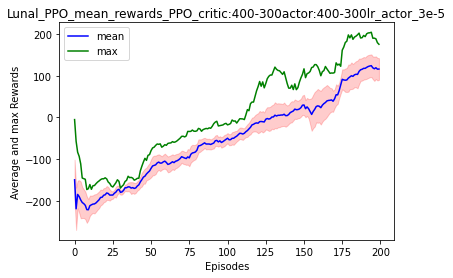

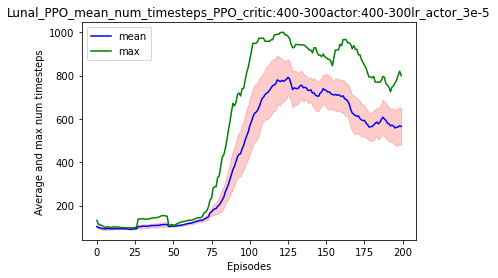

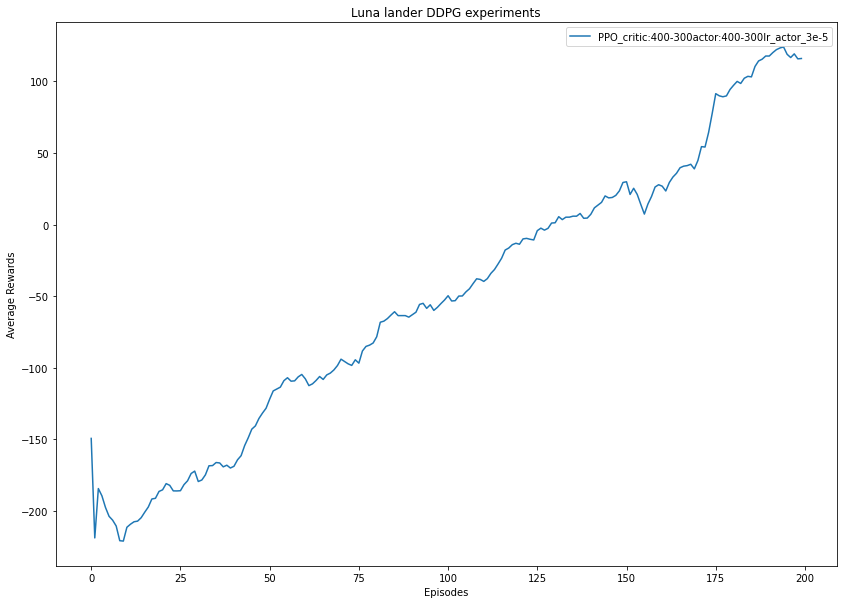

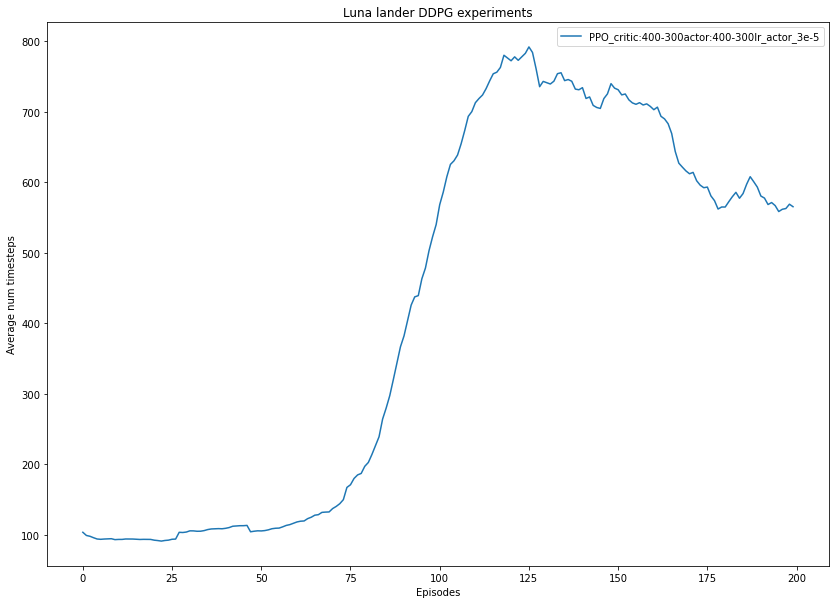

In [7]:


ppo_dict_results = experiment_luna_lander(device, RUNS_DIR, SAVED_DIR, NUM_EPISODES, CONFIGS_PPO_LUNA_LANDER, NUM_EXPERIMENTS,
                                          num_episodes_avg=NUM_EPISODES_AVG, train=True, agent_type='PPO')


## Load from a prepared pickle

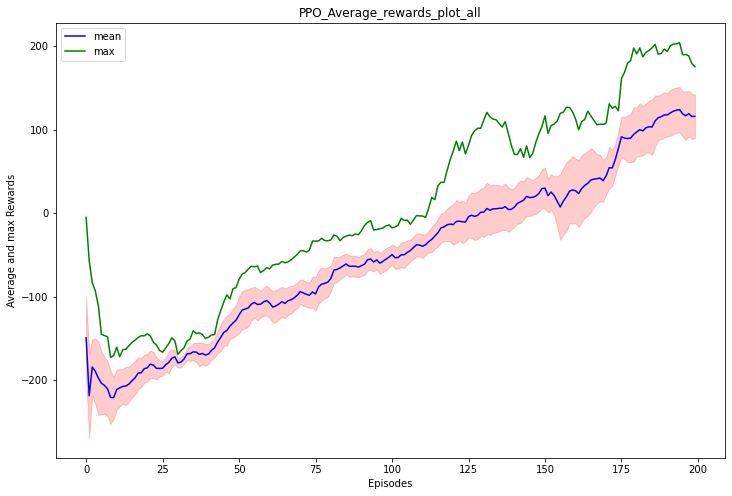

In [12]:
#Load from saved pickle of results
ppo_dict_results=load_from_pickle(PICKLE_PPO_RESULTS)

plot_episodes(ppo_dict_results['rewards_mean'][0],ppo_dict_results['rewards_std'][0],ppo_dict_results['rewards_max'][0],'Average and max Rewards', 'PPO_Average_rewards_plot_all', SAVED_DIR, 'PPO_Average_rewards_plot_all')

We can see that in only 200 epsiodes the agents learn and achieve highest score for 200 points. The avarage is a bit less which tells us the perofrmence is much dependent on initalizations and some randomess of sampling the actions during the game.

### Show running model on environment episodes and render on the best model-loaded from checkpoint

In [11]:

#Running avarages of 20 
NUM_EPISODES_AVG=20


#We will run for 200 episodes
NUM_EPISODES = 5




#Configuration fro PPO
BEST_CONFIG_PPO_LUNA_LANDER = [
        {'run_name': "test_PPO_critic:400-300actor:400-300lr_actor_3e-5", 'batch_size': 64,
         "critic_linear_sizes": [400, 300], "actor_linear_sizes": [400, 300], "config_optim": {'lr': 0.00003}
         , "capacity": 1024, "lambda_smoothing": 0.95, "num_epochs": 5,
         "gamma": 0.99, "checkpoint": {"critic":'PPO_BEST_CRITIC_model.pth', 
                       "actor":'PPO_BEST_ACTOR_model.pth'}}]

NUM_EXPERIMENTS = 1
BATCH_SIZE = 64

*********Start Running config: test_PPO_critic:400-300actor:400-300lr_actor_3e-5*************
Episode 0/5 Total Reward: 265.14 Num Timesteps: 320.00 Avg Reward: 265.14 Avg Timesteps: 320.00
Episode 1/5 Total Reward: 278.87 Num Timesteps: 271.00 Avg Reward: 272.00 Avg Timesteps: 295.50
Episode 2/5 Total Reward: 216.96 Num Timesteps: 325.00 Avg Reward: 253.66 Avg Timesteps: 305.33
Episode 3/5 Total Reward: 249.57 Num Timesteps: 387.00 Avg Reward: 252.63 Avg Timesteps: 325.75
Episode 4/5 Total Reward: 249.96 Num Timesteps: 299.00 Avg Reward: 252.10 Avg Timesteps: 320.40


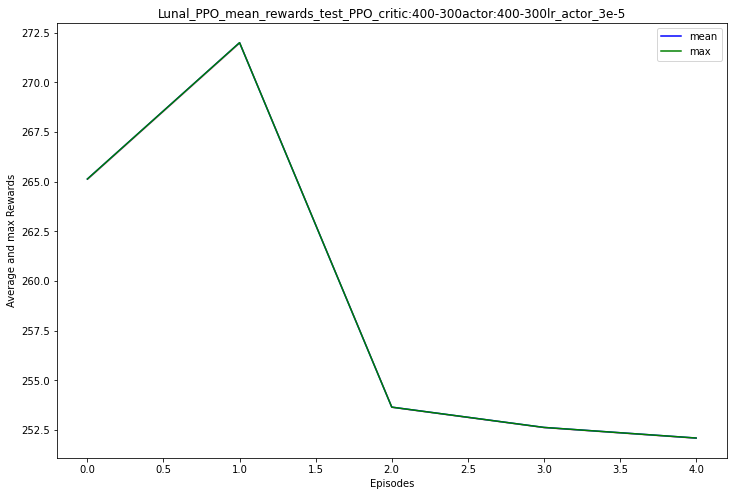

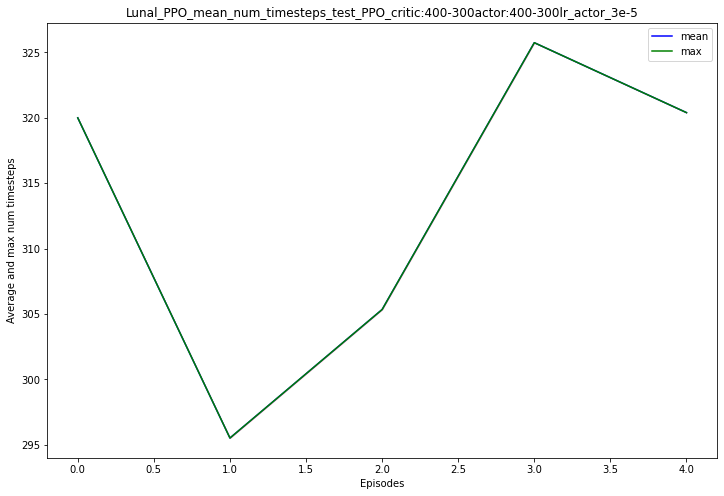

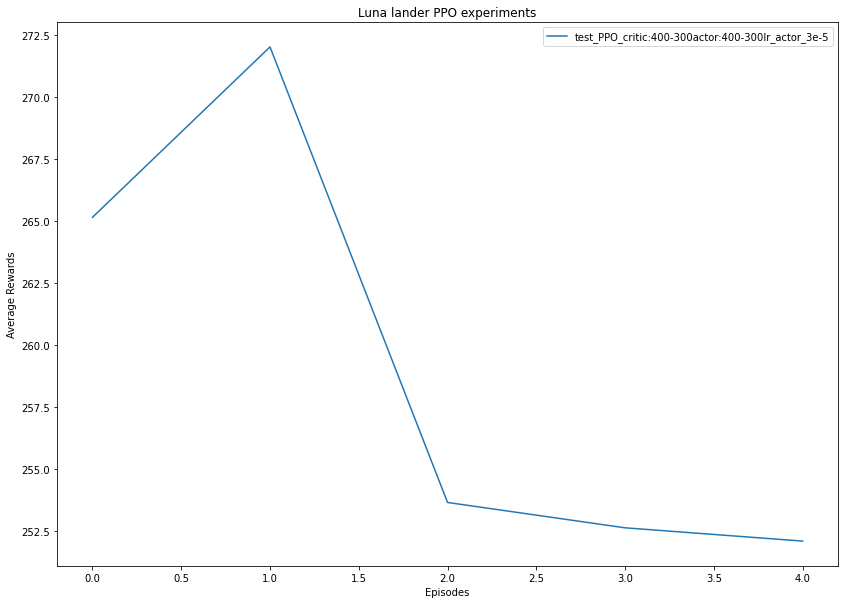

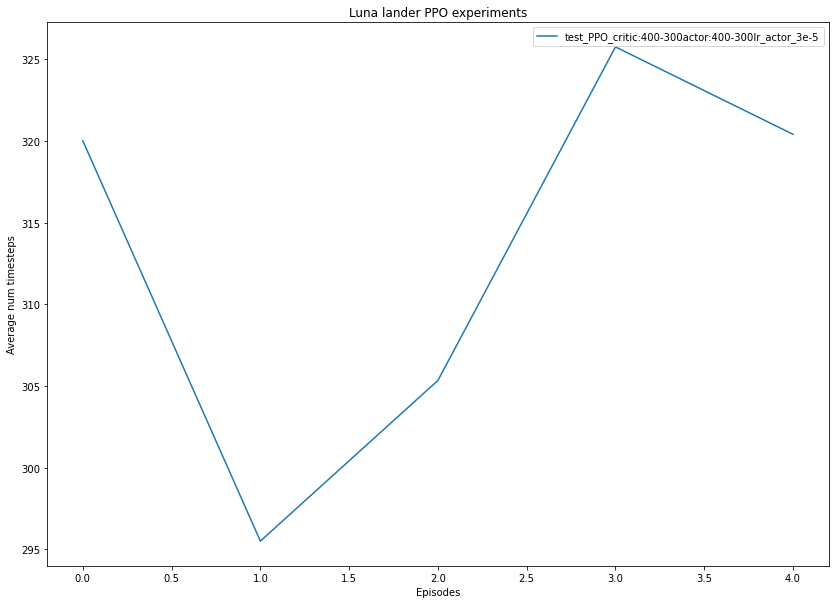

In [12]:
eval_results=luna_lander.experiment_luna_lander(device, RUNS_DIR, SAVED_BEST, NUM_EPISODES, BEST_CONFIG_PPO_LUNA_LANDER, NUM_EXPERIMENTS, num_episodes_avg=NUM_EPISODES_AVG, agent_type='PPO', train=False, save_freq=None, render=True)